# Import Libraries

In [1]:
# packages for parsing and data manipulation
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import requests
import json
import time
import math
import datetime

# reddit API wrapper
import praw

# dask for parallelize
import dask.dataframe as dd
from dask.multiprocessing import get

# plotting
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

# Function Definitions

In [2]:
# make a request for pushshift.io
def make_pushshift_request(uri, max_retries = 5):
    def fire_away(uri):
        response = requests.get(uri)
        assert response.status_code == 200
        return json.loads(response.content)
    current_tries = 1
    while current_tries < max_retries:
        try:
            time.sleep(1)
            response = fire_away(uri)
            return response
        except:
            time.sleep(1)
            current_tries += 1
    return fire_away(uri)

In [3]:
# build uri from start and end time
def build_uri(start_epoch, end_epoch, subreddit='IsTodayFridayThe13th'):
    return 'https://api.pushshift.io/reddit/submission/search?' + \
        'subreddit='+subreddit + \
        '&after='+str(start_epoch) + \
        '&before='+str(end_epoch) + \
        '&size=500'

In [4]:
# split the date range into acceptable size for pushshift.io API
def get_date_ranges(start_date='1/10/2017', end_date=datetime.datetime.date(datetime.datetime.now())):
    date_range = pd.Series(pd.date_range(start=start_date, end=end_date))
    num_days_per_split = len(date_range)/math.ceil(len(date_range)/500)
    return date_range.groupby(np.arange(len(date_range))//num_days_per_split).agg(['first', 'last'])

In [5]:
# only keep necessary fields in request json
def clean_request_json(request_results):
    # keep only a few properties from the request results
    for submission in request_results['data']:
        for element in list(submission):
            if element not in ['id', 'created_utc', 'subreddit_subscribers']:
                submission.pop(element, None)
    return request_results

In [6]:
# given id number of post, return score and number of comments of post
def get_submission_info(id_num):
    sub = reddit.submission(id=id_num)
    return sub.score, sub.num_comments

In [7]:
# find all Friday the 13ths between two dates
def get_friday_the_13ths(start_date='1/10/2017', end_date=datetime.datetime.date(datetime.datetime.now())):
    friday_the_13ths = []
    for d in pd.date_range(start=start_date, end=end_date).to_pydatetime().tolist():
        if ((d.day == 13) & (d.weekday()==4)):
            friday_the_13ths.append(d.strftime('%Y-%m-%d'))
    return friday_the_13ths

In [149]:
# add days to dates
def add_days(date, num_days):
    return (datetime.datetime.strptime(date, '%Y-%m-%d') + datetime.timedelta(num_days)).strftime('%Y-%m-%d')

'2018-08-05'

# Read in Credentials for Reddit API

In [8]:
# read credentials for Reddit API, stored on local text file
with open("credentials.txt","r") as credentials_file:
    credentials = credentials_file.readlines()
    _client_id = credentials[0].strip()
    _client_secret = credentials[1].strip()
    _username = credentials[2].strip()
    _password = credentials[3].strip()
    _user_agent = credentials[4].strip()
credentials_file.close()

In [9]:
# reddit instance from praw
reddit = praw.Reddit(client_id=_client_id,
                     client_secret=_client_secret,
                     username=_username,
                     password=_password,
                     user_agent=_user_agent)

# delete credentials variables
del _client_id, _client_secret, _username, _password, _user_agent

# Extract and Manipulate Data

In [10]:
# store all results
df_total = pd.DataFrame()

In [11]:
# get date_ranges
date_ranges = get_date_ranges()
date_ranges_num_rows = len(date_ranges.index)

# iterate through each date range
for date_ranges_index in range(0, len(date_ranges.index)):
    
    # find epoch value for start and end dates
    start_date_epoch = date_ranges['first'][date_ranges_index].astype('datetime64[s]').astype('int')
    end_date_epoch = date_ranges['last'][date_ranges_index].astype('datetime64[s]').astype('int')
    
    # make request
    uri = build_uri(start_date_epoch, end_date_epoch)
    request_results = make_pushshift_request(uri)
    
    # remove unnecessary fields
    request_results = clean_request_json(request_results)
    
    # flatten the request results
    df = json_normalize(request_results['data'])
    
    # parallelize process for finding score and comments count
    ddata = dd.from_pandas(df, npartitions=16)
    df['score'], df['num_comments'] = zip(*df.id.map(lambda id_num: get_submission_info(id_num)))
    
    # append to total results
    df_total = df_total.append(df, ignore_index=True, sort=True)
    
# add date column
df_total['date'] = df_total.created_utc.apply(lambda t: time.strftime('%Y-%m-%d', time.gmtime(t)))

In [12]:
# save results, for easier loading in the future
df_total.to_csv("df_total.csv", index=False)

# Plot Data

### Popularity of /r/IsTodayFridayThe13th Posts

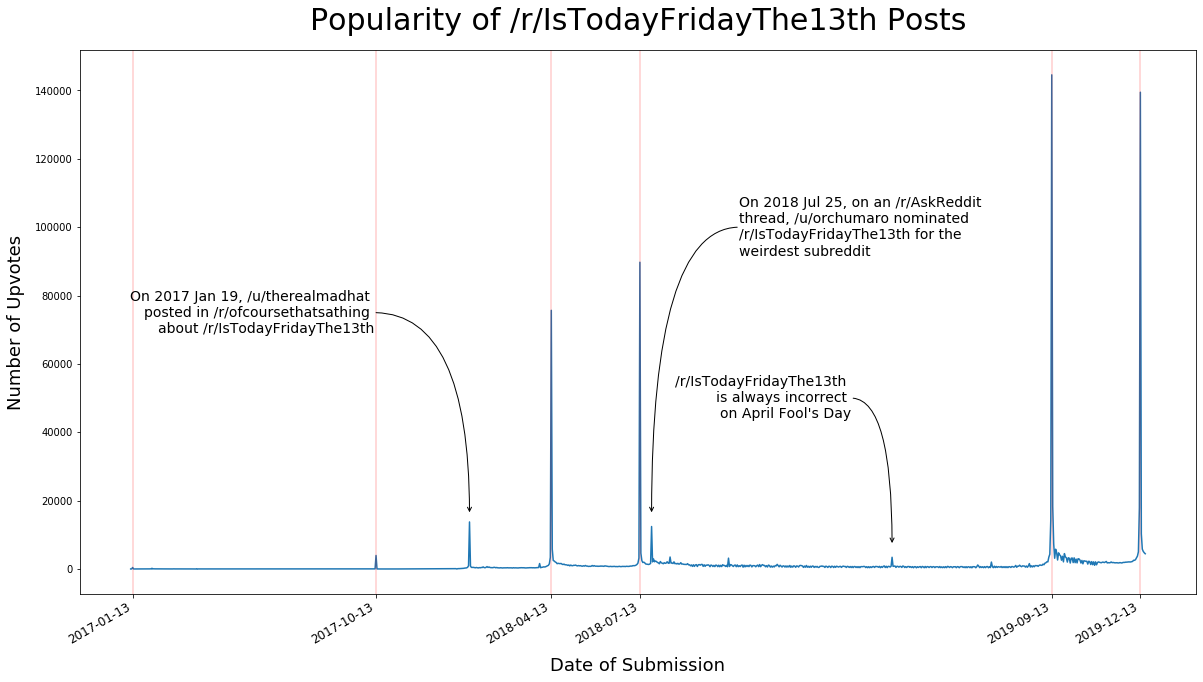

In [116]:
# set up figure size
fig, ax = plt.subplots(figsize=(20,10))

# figure metadata
ax.set_title('Popularity of /r/IsTodayFridayThe13th Posts', fontsize= 30, pad=20)
plt.xlabel('Date of Submission', fontsize= 18, labelpad=10)
plt.ylabel('Number of Upvotes', fontsize= 18, labelpad=10)

# plot data
ax.plot(df_total.date, df_total.score)
# ax.plot(df_total.date, df_total.num_comments)
# ax.plot(df_total.date, df_total.subreddit_subscribers)

# lines for Friday the 13th
friday_the_13ths = get_friday_the_13ths()
for i in friday_the_13ths:
    plt.axvline(i, color='r', alpha=0.2)
plt.xticks(friday_the_13ths, rotation=30, ha='right', fontsize=12)

# annotation for January 19, 2017: https://www.reddit.com/r/ofcoursethatsathing/comments/7rhxmr/god_i_love_reddit/
plt.annotate('', xy=(348, 16000), xycoords='data', xytext=(250, 75000), textcoords='data',
             arrowprops=dict(arrowstyle='->', color='0', connectionstyle='angle3,angleA=0,angleB=90'))
plt.annotate('On 2017 Jan 19, /u/therealmadhat \nposted in /r/ofcoursethatsathing \nabout /r/IsTodayFridayThe13th', 
             xy=(250, 75000), va='center', ha='right', fontsize=14)

# annotation for July 25, 2018: https://www.reddit.com/r/AskReddit/comments/91nmy3/whats_the_weirdest_subreddit_on_the_site/e2zp5y5/
plt.annotate('', xy=(535, 16000), xycoords='data', xytext=(625, 100000), textcoords='data',
             arrowprops=dict(arrowstyle='->', color='0', connectionstyle='angle3,angleA=0,angleB=90'))
plt.annotate('On 2018 Jul 25, on an /r/AskReddit \nthread, /u/orchumaro nominated \n/r/IsTodayFridayThe13th for the \nweirdest subreddit', 
             xy=(625, 100000), va='center', ha='left', fontsize=14)

# annotate for April 1st
plt.annotate('', xy=(782, 7000), xycoords='data', xytext=(740, 50000), textcoords='data',
             arrowprops=dict(arrowstyle='->', color='0', connectionstyle='angle3,angleA=0,angleB=90'))
plt.annotate('/r/IsTodayFridayThe13th \nis always incorrect \non April Fool\'s Day', 
             xy=(740, 50000), va='center', ha='right', fontsize=14)

# save figure
plt.savefig('IsTodayFridayThe13thUpvotes.png')

# show plot
plt.show()

### Number of Comments for /r/IsTodayFridayThe13th Posts

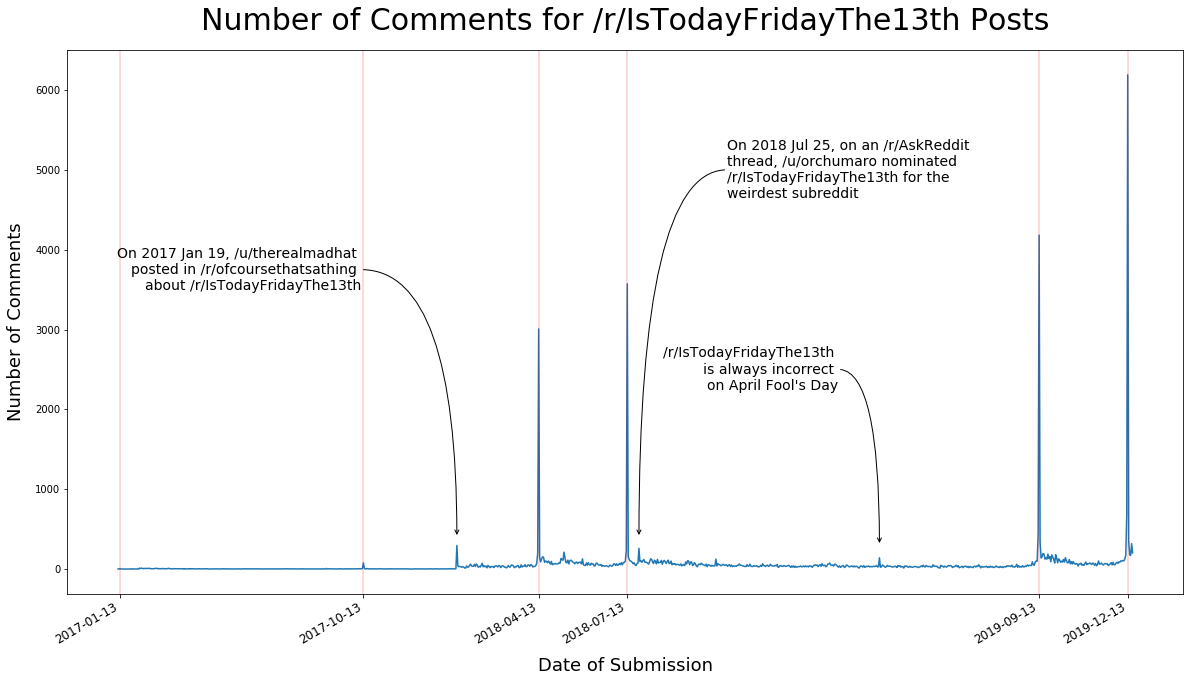

In [115]:
# set up figure size
fig, ax = plt.subplots(figsize=(20,10))

# figure metadata
ax.set_title('Number of Comments for /r/IsTodayFridayThe13th Posts', fontsize= 30, pad=20)
plt.xlabel('Date of Submission', fontsize= 18, labelpad=10)
plt.ylabel('Number of Comments', fontsize= 18, labelpad=10)

# plot data
# ax.plot(df_total.date, df_total.score)
ax.plot(df_total.date, df_total.num_comments)
# ax.plot(df_total.date, df_total.subreddit_subscribers)

# lines for Friday the 13th
friday_the_13ths = get_friday_the_13ths()
for i in friday_the_13ths:
    plt.axvline(i, color='r', alpha=0.2)
plt.xticks(friday_the_13ths, rotation=30, ha='right', fontsize=12)

# annotation for January 19, 2017: https://www.reddit.com/r/ofcoursethatsathing/comments/7rhxmr/god_i_love_reddit/
plt.annotate('', xy=(348, 400), xycoords='data', xytext=(250, 3750), textcoords='data',
             arrowprops=dict(arrowstyle='->', color='0', connectionstyle='angle3,angleA=0,angleB=90'))
plt.annotate('On 2017 Jan 19, /u/therealmadhat \nposted in /r/ofcoursethatsathing \nabout /r/IsTodayFridayThe13th', 
             xy=(250, 3750), va='center', ha='right', fontsize=14)

# annotation for July 25, 2018: https://www.reddit.com/r/AskReddit/comments/91nmy3/whats_the_weirdest_subreddit_on_the_site/e2zp5y5/
plt.annotate('', xy=(535, 400), xycoords='data', xytext=(625, 5000), textcoords='data',
             arrowprops=dict(arrowstyle='->', color='0', connectionstyle='angle3,angleA=0,angleB=90'))
plt.annotate('On 2018 Jul 25, on an /r/AskReddit \nthread, /u/orchumaro nominated \n/r/IsTodayFridayThe13th for the \nweirdest subreddit', 
             xy=(625, 5000), va='center', ha='left', fontsize=14)

# annotate for April 1st
plt.annotate('', xy=(782, 300), xycoords='data', xytext=(740, 2500), textcoords='data',
             arrowprops=dict(arrowstyle='->', color='0', connectionstyle='angle3,angleA=0,angleB=90'))
plt.annotate('/r/IsTodayFridayThe13th \nis always incorrect \non April Fool\'s Day', 
             xy=(740, 2500), va='center', ha='right', fontsize=14)

# save figure
plt.savefig('IsTodayFridayThe13thComments.png')

# show plot
plt.show()

### Number of Subscribers for /r/IsTodayFridayThe13th Posts

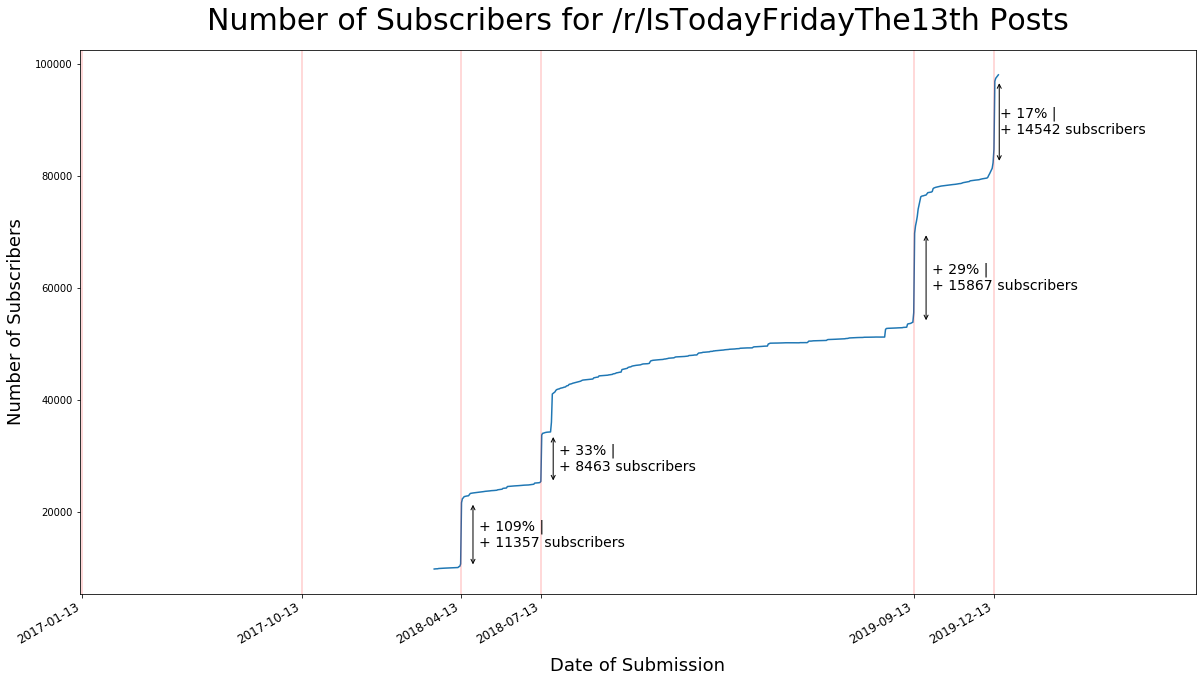

In [208]:
# set up figure size
fig, ax = plt.subplots(figsize=(20,10))
plt.xlim(right=200+(datetime.datetime.strptime('2019-12-12', '%Y-%m-%d') - datetime.datetime.strptime('2017-01-10', '%Y-%m-%d')).days)

# figure metadata
ax.set_title('Number of Subscribers for /r/IsTodayFridayThe13th Posts', fontsize= 30, pad=20)
plt.xlabel('Date of Submission', fontsize= 18, labelpad=10)
plt.ylabel('Number of Subscribers', fontsize= 18, labelpad=10)

# plot data
# ax.plot(df_total.date, df_total.score)
# ax.plot(df_total.date, df_total.num_comments)
ax.plot(df_total.date, df_total.subreddit_subscribers)

# lines for Friday the 13th
friday_the_13ths = get_friday_the_13ths()
for i in friday_the_13ths:
    plt.axvline(i, color='r', alpha=0.2)
plt.xticks(friday_the_13ths, rotation=30, ha='right', fontsize=12)

# annotations for Friday the 13ths
for idx, d in enumerate(get_friday_the_13ths(start_date='2018-04-01')):

    d1_subs = df_total[df_total['date'] == add_days(d, -1)].iloc[0]['subreddit_subscribers']
    d2_subs = df_total[df_total['date'] == add_days(d, 1)].iloc[0]['subreddit_subscribers']
    plt.annotate('', xy=(add_days(d, 14), d1_subs), xycoords='data', 
                 xytext=(add_days(d, 14), d2_subs), textcoords='data',
                 arrowprops=dict(arrowstyle='<->', color='0', connectionstyle='angle3,angleA=0,angleB=90'))
    plt.annotate('+ {}% |\n+ {} subscribers'.format(int(100*(d2_subs-d1_subs)/d1_subs),int(d2_subs-d1_subs)), 
                 xy=(add_days(d, 21), np.mean([d1_subs, d2_subs])), va='center', ha='left', fontsize=14)

# save figure
plt.savefig('IsTodayFridayThe13thSubscribers.png')

# show plot
plt.show()